# Life Expectancy: Linear Regression Modelling

### Table of contents

* [Loading and exploring the data](#chapter1)
* [Functions](#chapter2)
* [Variables for data cleaning](#chapter3)
* [Data cleaning pipeline](#chapter4)
* [Preparing and plotting data before modelling](#chapter5)
* [Data transformation](#chapter6)
* [Linear regression](#chapter7)
* [Model validation](#chapter8)
* [Feature importance](#chapter9)

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import boxcox

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

# suppress warnings about "value is trying to be set on a copy of a slice from a DataFrame"
pd.options.mode.chained_assignment = None 

## Loading and exploring the data <a class="anchor" id="chapter1"></a>

In [112]:
life_df = pd.read_csv("Data/life_expectancy.csv")
life_df

country country_code           region  year  \
0                               Angola          AGO           Africa  2000   
1                               Angola          AGO           Africa  2001   
2                               Angola          AGO           Africa  2002   
3                               Angola          AGO           Africa  2003   
4                               Angola          AGO           Africa  2004   
...                                ...          ...              ...   ...   
3106  Lao People's Democratic Republic          LAO  Western Pacific  2012   
3107  Lao People's Democratic Republic          LAO  Western Pacific  2013   
3108  Lao People's Democratic Republic          LAO  Western Pacific  2014   
3109  Lao People's Democratic Republic          LAO  Western Pacific  2015   
3110  Lao People's Democratic Republic          LAO  Western Pacific  2016   

      life_expect  life_exp60  adult_mortality  infant_mort  age1-4mort  \
0        47.33730    14.73400         383.5583     0.137985    0.025695   
1        48.19789    14.95963         372.3876     0.133675    0.024500   
2        49.42569    15.20010         354.5147     0.128320    0.023260   
3        50.50266    15.39144         343.2169     0.122040    0.021925   
4        51.52863    15.56860         333.8711     0.115700    0.020545   
...           ...         ...              ...          ...         ...   
3106     64.49448    16.57977         209.2666     0.055840    0.004845   
3107     64.79716    16.64219         205.1459     0.055350    0.004600   
3108     65.10757    16.70787         200.8204     0.054585    0.004405   
3109     65.45008    16.77074         196.6613     0.053465    0.004160   
3110     65.79089    16.83024         192.7939     0.051895    0.003990   

      alcohol  ...  che_gdp    une_pop  une_infant  une_life  une_hiv  \
0     1.47439  ...  1.90860  16395.473       122.2    46.522      1.0   
1     1.94025  ...  4.48352  16945.753       118.9    47.059      1.1   
2     2.07512  ...  3.32946  17519.417       115.1    47.702      1.2   
3     2.20275  ...  3.54797  18121.479       110.8    48.440      1.3   
4     2.41274  ...  3.96720  18758.145       106.2    49.263      1.3   
...       ...  ...      ...        ...         ...       ...      ...   
3106  6.29833  ...  2.07638   6444.530        47.5    65.267      0.3   
3107  6.42186  ...  2.39985   6541.304        45.6    65.717      0.3   
3108  6.64447  ...  2.29846   6639.756        43.7    66.144      0.3   
3109  6.83826  ...  2.45366   6741.164        42.0    66.546      0.3   
3110  7.11148  ...  2.36087   6845.846        40.4    66.924      0.3   

      une_gni  une_poverty  une_edu_spend  une_literacy  une_school  
0      2530.0         32.3        2.60753           NaN         NaN  
1      2630.0          NaN            NaN      67.40542         NaN  
2      3180.0          NaN            NaN           NaN         NaN  
3      3260.0          NaN            NaN           NaN         NaN  
4      3560.0          NaN            NaN           NaN         NaN  
...       ...          ...            ...           ...         ...  
3106   4570.0         22.7        1.82147           NaN         NaN  
3107   4980.0          NaN        3.23381           NaN         NaN  
3108   5440.0          NaN        2.93781           NaN         NaN  
3109   5810.0          NaN            NaN      84.66104         NaN  
3110   6190.0          NaN            NaN           NaN         NaN  

[3111 rows x 32 columns]

### 1. Checking for missing values 

In [113]:
life_df.isna().sum()

country               0
country_code          0
region                0
year                  0
life_expect           0
life_exp60            0
adult_mortality       0
infant_mort           0
age1-4mort            0
alcohol              50
bmi                  34
age5-19thinness      34
age5-19obesity       34
hepatitis           569
measles              19
polio                19
diphtheria           19
basic_water          32
doctors            1331
hospitals          2981
gni_capita          682
gghe-d              100
che_gdp             117
une_pop              37
une_infant            0
une_life              0
une_hiv             741
une_gni             117
une_poverty        2198
une_edu_spend      1286
une_literacy       2540
une_school         2306
dtype: int64

### 2. Checking for correlations
<br>
To be able to decide which columns to drop we looked for highly correlated columns.

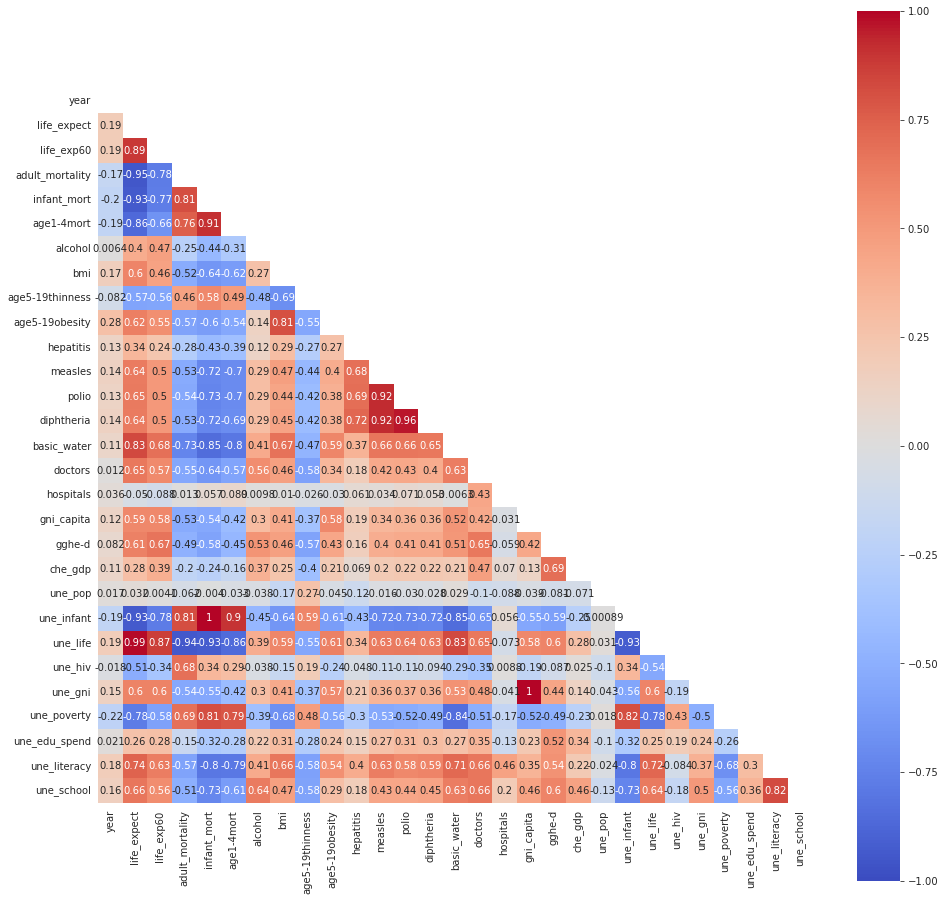

In [114]:
corr = life_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 16))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

## Functions <a class="anchor" id="chapter2"></a>

Defining functions which will be used later to build a data cleaning pipeline. 

In [115]:
def headers_to_lowercase (df):
    df.columns = df.columns.str.lower()
    return df


def text_to_lowercase (df):
    df = df.applymap(lambda s: s.lower() if type(s) == str else s)
    return df   


def drop_columns (df, list_of_columns_to_drop):    
    df.drop(columns = list_of_columns_to_drop, inplace=True)
    return df


def drop_rows (df, country_drop_list):
    df = df[~df['country'].isin(country_drop_list)]
    return df


def fill_na_in_population_with_values_from_dict (df):
    
    singapore_pop_dict = {2000:4028.871 , 2001:4077.145 , 2002:4104.419 , 2003:4129.225 , 2004: 4177.213 , 2005: 4265.687 , 2006:4402.331 , 2007:4578.630 , 2008:4775.804 , 2009:4966.614 , 2010:5131.172 , 2011:5263.636, 2012:5369.476, 2013:5453.737, 2014:5525.626, 2015:5592.152, 2016:5653.634}
    ukraine_pop_dict = {2014:45111.532, 2015:44921.639, 2016: 44713.702}
    brazil_pop_dict = {2000:174790.340, 2006: 188167.356, 2010:195713.635}
    
    df['une_pop'][df['country']=="singapore"] = df['une_pop'][df['country']=="singapore"].fillna(df['year'].map(singapore_pop_dict))
    df['une_pop'][df['country']=="brazil"] = df['une_pop'][df['country']=="brazil"].fillna(df['year'].map(brazil_pop_dict))
    df['une_pop'][df['country']=="ukraine"] = df['une_pop'][df['country']=="ukraine"].fillna(df['year'].map(ukraine_pop_dict))
    
    return df


def change_col_names (df, column_name_dict):
    df.rename(columns=column_name_dict, inplace= True)
    return df


def replace_nans_with_country_mean (df, list_of_categories):
    for i in list_of_categories:
        df[i] = df[i].fillna(df.groupby('country')[i].transform('mean'))
    return df


def round_floats (df):
    df = df.applymap(lambda s: np.round(s,5) if type(s) == float else s)
    return df 

## Variables for data cleaning <a class="anchor" id="chapter3"></a>
<br>
After exploring our data we decided which columns and rows should be dropped. The main reason for dropping columns and rows was a big amount of missing values which could not easily be replaced. 
<br><br>
For filling NaNs we used the mean of the category and the corresponding country.

In [116]:
list_of_columns_to_drop = ['country_code','hospitals','gni_capita','une_hiv','une_poverty','une_edu_spend','une_literacy','une_school','une_infant','une_life','hepatitis','life_exp60','infant_mort','diphtheria','measles','bmi','adult_mortality','age1-4mort']
country_drop_list = ['somalia','sudan','montenegro','south sudan',"democratic people's republic of korea", 'albania', 'bosnia and herzegovina','syrian arab republic','cuba','djibouti']
column_name_dict = {'life_expect':'life_expectancy','life_exp60':'life_expectancy_at_60','infant_mort':'infant_mortality', 'age5-19thinness':'age_5-19_thinness', 'age5-19obesity':'age_5-19_obesity','polio':'polio_vacc', 'basic_water':'basic_water_access', 'doctors':'doctors_per_10000', 'une_pop':'population', 'une_gni':'gni'}
list_of_categories = ['alcohol','doctors_per_10000','gni','polio_vacc','basic_water_access','gghe-d','che_gdp']

## Data cleaning pipeline <a class="anchor" id="chapter4"></a>

In [117]:
life_df = (life_df
.pipe(headers_to_lowercase)
.pipe(text_to_lowercase)
.pipe(drop_columns, list_of_columns_to_drop)
.pipe(drop_rows, country_drop_list)
.pipe(fill_na_in_population_with_values_from_dict)
.pipe(change_col_names, column_name_dict)
.pipe(replace_nans_with_country_mean, list_of_categories)
.pipe(round_floats)
)

In [118]:
life_df.isna().sum()

country               0
region                0
year                  0
life_expectancy       0
alcohol               0
age_5-19_thinness     0
age_5-19_obesity      0
polio_vacc            0
basic_water_access    0
doctors_per_10000     0
gghe-d                0
che_gdp               0
population            0
gni                   0
dtype: int64

In [119]:
life_df.to_csv("Data/cleaned_life_expectancy_df.csv", index=False)

## Preparing and plotting data before modelling <a class="anchor" id="chapter5"></a>

After multiple trials we decided that we will run the model on the numerical values only - using the categorical values caused overfitting of the model. 

### 1. Getting numerical variables

In [120]:
life_num = life_df._get_numeric_data()
life_num = life_num.drop(columns='year')
life_num

life_expectancy  alcohol  age_5-19_thinness  age_5-19_obesity  \
0            47.33730  1.47439               11.0               0.5   
1            48.19789  1.94025               10.9               0.5   
2            49.42569  2.07512               10.7               0.6   
3            50.50266  2.20275               10.5               0.7   
4            51.52863  2.41274               10.3               0.8   
...               ...      ...                ...               ...   
3106         64.49448  6.29833                9.2               3.1   
3107         64.79716  6.42186                9.1               3.5   
3108         65.10757  6.64447                9.0               3.8   
3109         65.45008  6.83826                8.9               4.2   
3110         65.79089  7.11148                8.9               4.7   

      polio_vacc  basic_water_access  doctors_per_10000   gghe-d  che_gdp  \
0           21.0            41.14431            0.96700  1.11099  1.90860   
1           28.0            42.25467            0.96700  2.04631  4.48352   
2           22.0            43.37680            0.96700  1.30863  3.32946   
3           21.0            44.36387            0.96700  1.46560  3.54797   
4           18.0            45.35134            0.62100  1.68663  3.96720   
...          ...                 ...                ...      ...      ...   
3106        78.0            72.07056            1.80000  0.43670  2.07638   
3107        86.0            74.05544            4.49300  0.71266  2.39985   
3108        88.0            76.02924            4.94900  0.68373  2.29846   
3109        80.0            77.99142            3.77612  0.86391  2.45366   
3110        66.0            79.94190            3.77612  0.76495  2.36087   

      population     gni  
0      16395.473  2530.0  
1      16945.753  2630.0  
2      17519.417  3180.0  
3      18121.479  3260.0  
4      18758.145  3560.0  
...          ...     ...  
3106    6444.530  4570.0  
3107    6541.304  4980.0  
3108    6639.756  5440.0  
3109    6741.164  5810.0  
3110    6845.846  6190.0  

[2941 rows x 11 columns]

### 2. Plotting a heatmap and scatter plots to look for correlations

We already decided beforehand after multiple trial and errors which columns should be deleted for sure, but here we're checking one more time if there is anything that might still cause overfitting of the model. 

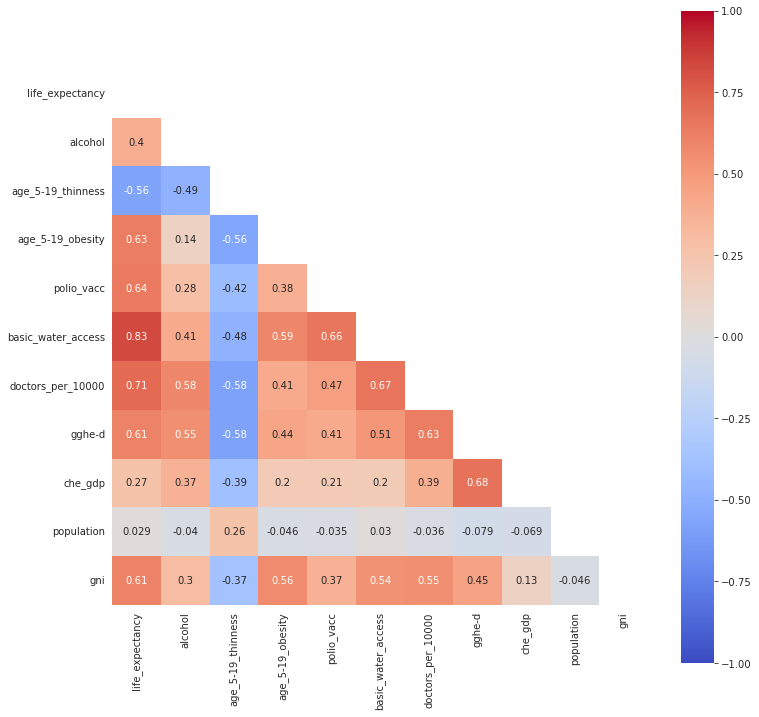

In [121]:
corr = life_num.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

array([[<AxesSubplot:title={'center':'life_expectancy'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'age_5-19_thinness'}>],
       [<AxesSubplot:title={'center':'age_5-19_obesity'}>,
        <AxesSubplot:title={'center':'polio_vacc'}>,
        <AxesSubplot:title={'center':'basic_water_access'}>],
       [<AxesSubplot:title={'center':'doctors_per_10000'}>,
        <AxesSubplot:title={'center':'gghe-d'}>,
        <AxesSubplot:title={'center':'che_gdp'}>],
       [<AxesSubplot:title={'center':'population'}>,
        <AxesSubplot:title={'center':'gni'}>, <AxesSubplot:>]],
      dtype=object)

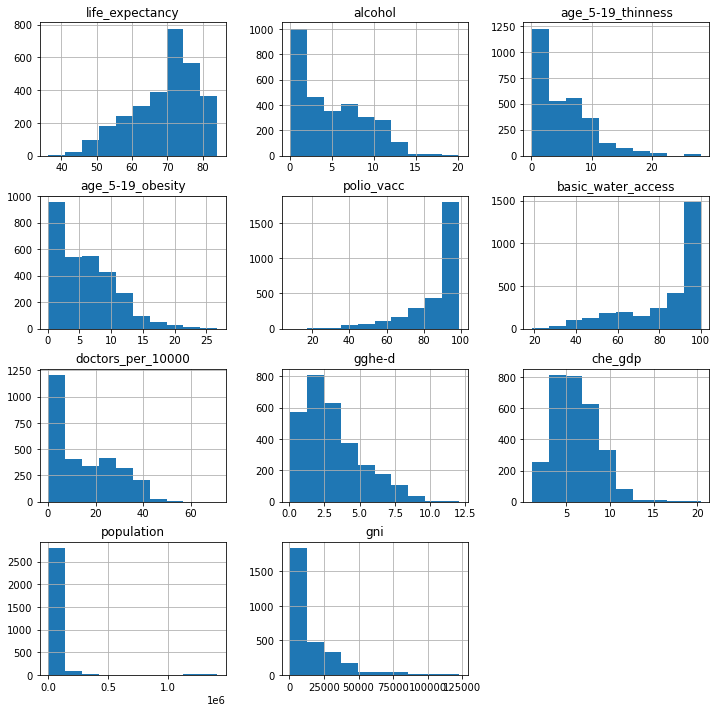

In [122]:
life_num.hist(figsize=[12,12])

## Data transformation <a class="anchor" id="chapter6"></a>

### 1. X / y split
<br>
Our target variable is the life expectancy column.

In [123]:
X = life_num.drop('life_expectancy', axis=1)

y = life_num['life_expectancy']

### 2. Train / Test split
<br>
We are splitting the data randomly in ratio 70/30.

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.30,random_state=100)

### 3. Scaling the data
<br>
Since we are only using the numerical data we are going to use the Standard Scaler to standardize all columns. 

In [125]:
#TRAIN

std_scaler=StandardScaler().fit(X_train)   

X_train_scaled=std_scaler.transform(X_train)

#TEST

X_test_scaled=std_scaler.transform(X_test)

## Linear Regression <a class="anchor" id="chapter7"></a>

### 1. Model fitting

In [126]:
model=LinearRegression()    
model.fit(X_train_scaled, y_train)

LinearRegression()

In [127]:
coef = list(model.coef_)
print('Our model coefficients are: ','\n', (', '.join(map(str, coef))),'\n','\n',' Our model intercept is: ', model.intercept_)

Our model coefficients are:  
 -0.7765498684910036, -0.8762167681588454, 0.8321871817693203, 1.1072294120297321, 3.9476926266267345, 1.5915281976331375, 1.6517594149858486, -0.6348191345619071, 0.667026681789763, 0.9366844736069038 
 
  Our model intercept is:  69.29048344023323


### 2. Making prediction on the test set

In [128]:
y_pred=model.predict(X_test_scaled)

result = pd.DataFrame({"y_test":y_test,"y_pred":y_pred})
result

y_test     y_pred
1818  82.36343  82.369772
134   62.06905  54.721659
1700  68.54817  62.760446
659   64.58259  65.734382
2977  63.46142  67.513999
...        ...        ...
818   73.42290  72.290897
648   59.28408  60.909321
2754  79.64923  77.127200
792   71.82126  67.346174
422   56.93072  60.889693

[883 rows x 2 columns]

### 3. Plotting
<br>
On the visualizations below we plotted the predicted vs. real values as well as the distribution of the residuals.

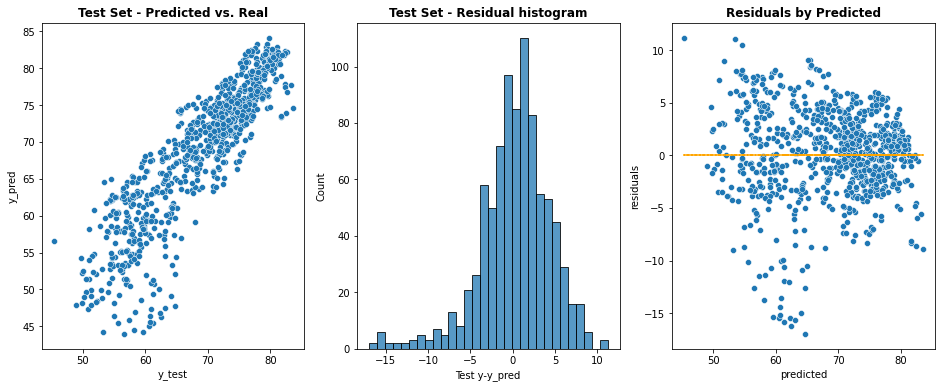

In [129]:
fig1, ax1 = plt.subplots(1,3, figsize=(16,6))

sns.scatterplot(x=y_pred, y=y_test, ax=ax1[0])
ax1[0].set_xlabel("y_test")
ax1[0].set_ylabel("y_pred")
ax1[0].set_title('Test Set - Predicted vs. Real', fontweight='bold')

sns.histplot(x = y_test-y_pred, ax = ax1[1])
ax1[1].set_xlabel("Test y-y_pred")
ax1[1].set_title('Test Set - Residual histogram', fontweight='bold')

sns.scatterplot(x = y_pred,y = y_test - y_pred, ax=ax1[2])
ax1[2].set_xlabel("predicted")
ax1[2].set_ylabel("residuals")
ax1[2].set_title('Residuals by Predicted', fontweight='bold')
ax1[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed', color='orange')

## Model validation <a class="anchor" id="chapter8"></a>

In [130]:
MSE = mse(y_test,y_pred) #average squared difference between observed and predicted values.
MAE = mae(y_test,y_pred) #measures the average magnitude of the errors in a set of predictions, without considering their direction.
RMSE = np.sqrt(MSE) #square root of the mean squared error.

R2_test = model.score(X_test_scaled, y_test)
Adj_R2_test = 1 - (1-R2_test)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

R2_train = model.score(X_train_scaled, y_train)
Adj_R2_train = 1 - (1-R2_train)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

print("The Mean Squared Error is: ", MSE) 
print("The Mean Absolute Error is: ", MAE)
print("The Root Mean Squared Error is: ", RMSE)
print('\n')
print("The R2 for the test set is: ", R2_test)
print("The Adjusted R2 for the test set is: ", Adj_R2_test)
print('\n')
print("The R2 for the train set is: ", R2_train)
print("The Adjusted R2 for the train set is: ", Adj_R2_train)

The Mean Squared Error is:  17.34156251554969
The Mean Absolute Error is:  3.106608405193972
The Root Mean Squared Error is:  4.164320174476224


The R2 for the test set is:  0.7915174463038918
The Adjusted R2 for the test set is:  0.7891265913303125


The R2 for the train set is:  0.7966910411746421
The Adjusted R2 for the train set is:  0.7943595164174705


## Features importance <a class="anchor" id="chapter9"></a>

In [131]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': abs(model.coef_)
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)

features_importances

Attribute  Importance
4  basic_water_access    3.947693
6              gghe-d    1.651759
5   doctors_per_10000    1.591528
3          polio_vacc    1.107229
9                 gni    0.936684
1   age_5-19_thinness    0.876217
2    age_5-19_obesity    0.832187
0             alcohol    0.776550
8          population    0.667027
7             che_gdp    0.634819